# Importing the necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import backtrader as bt
import scipy.stats as stats
import plotly.graph_objects as go
from datetime import datetime
import scipy.stats as stats
from scipy.stats import anderson, jarque_bera, shapiro, normaltest, kstest
from statsmodels.stats.diagnostic import lilliefors #Corrected import
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, f1_score
import os
import joblib #For saving the model

# Loading the Datasets

In [2]:
df = pd.read_csv('Data_sets/Banking_Data.csv')

In [3]:
df.head()

Symbol       Date     Open     High      Low    Close Percent Change  \
0  BANKING  7/29/2024  1604.17  1662.91  1569.17  1573.71         -0.04%   
1  BANKING  7/28/2024  1461.05  1574.81  1461.04  1574.34          9.90%   
2  BANKING  7/25/2024  1413.90  1434.64  1396.76  1432.58          1.35%   
3  BANKING  7/24/2024  1435.46  1452.12  1402.11  1413.44         -1.22%   
4  BANKING  7/23/2024  1399.35  1432.23  1374.74  1430.86          2.39%   

             Volume  
0  4,334,529,130.90  
1  3,962,874,692.70  
2  1,742,766,269.40  
3  1,958,365,254.40  
4  1,843,392,041.30

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol          1131 non-null   object 
 1   Date            1131 non-null   object 
 2   Open            1131 non-null   float64
 3   High            1131 non-null   float64
 4   Low             1131 non-null   float64
 5   Close           1131 non-null   float64
 6   Percent Change  1131 non-null   object 
 7   Volume          1131 non-null   object 
dtypes: float64(4), object(4)
memory usage: 70.8+ KB


In [6]:
df.shape

(1131, 8)

# Checking if there are NULL Values

In [102]:
df.isnull().sum()

Symbol            0
Date              0
Open              0
High              0
Low               0
Close             0
Percent Change    0
Volume            0
dtype: int64

In [7]:
df.tail()

Symbol      Date     Open     High      Low    Close Percent Change  \
1126  BANKING  8/7/2019  1121.46  1126.77  1114.92  1123.57          0.00%   
1127  BANKING  8/6/2019  1131.07  1131.07  1118.32  1120.61          0.00%   
1128  BANKING  8/5/2019  1133.33  1134.83  1128.01  1129.97          0.00%   
1129  BANKING  8/4/2019  1136.52  1139.09  1131.52  1132.80          0.00%   
1130  BANKING  8/1/2019  1140.22  1143.82  1134.80  1136.29          0.00%   

              Volume  
1126  176,374,000.00  
1127  278,084,992.00  
1128  183,203,008.00  
1129  203,803,008.00  
1130  161,744,000.00

In [3]:
categorical_columns = df.select_dtypes(include=['category', 'object']).columns
numerical_columns = df.select_dtypes(exclude=['category', 'object']).columns

### Plotting Boxplot to know if there are outliers

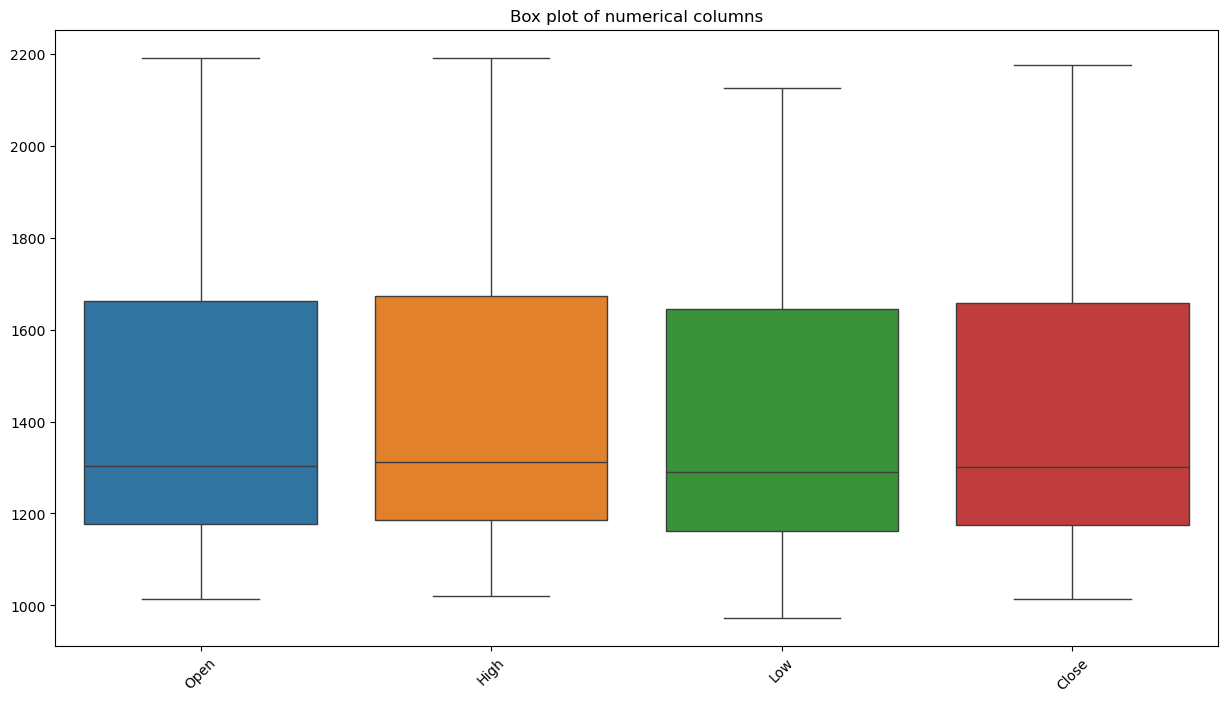

In [9]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numerical_columns])
plt.xticks(rotation=45)
plt.title('Box plot of numerical columns')
plt.show()

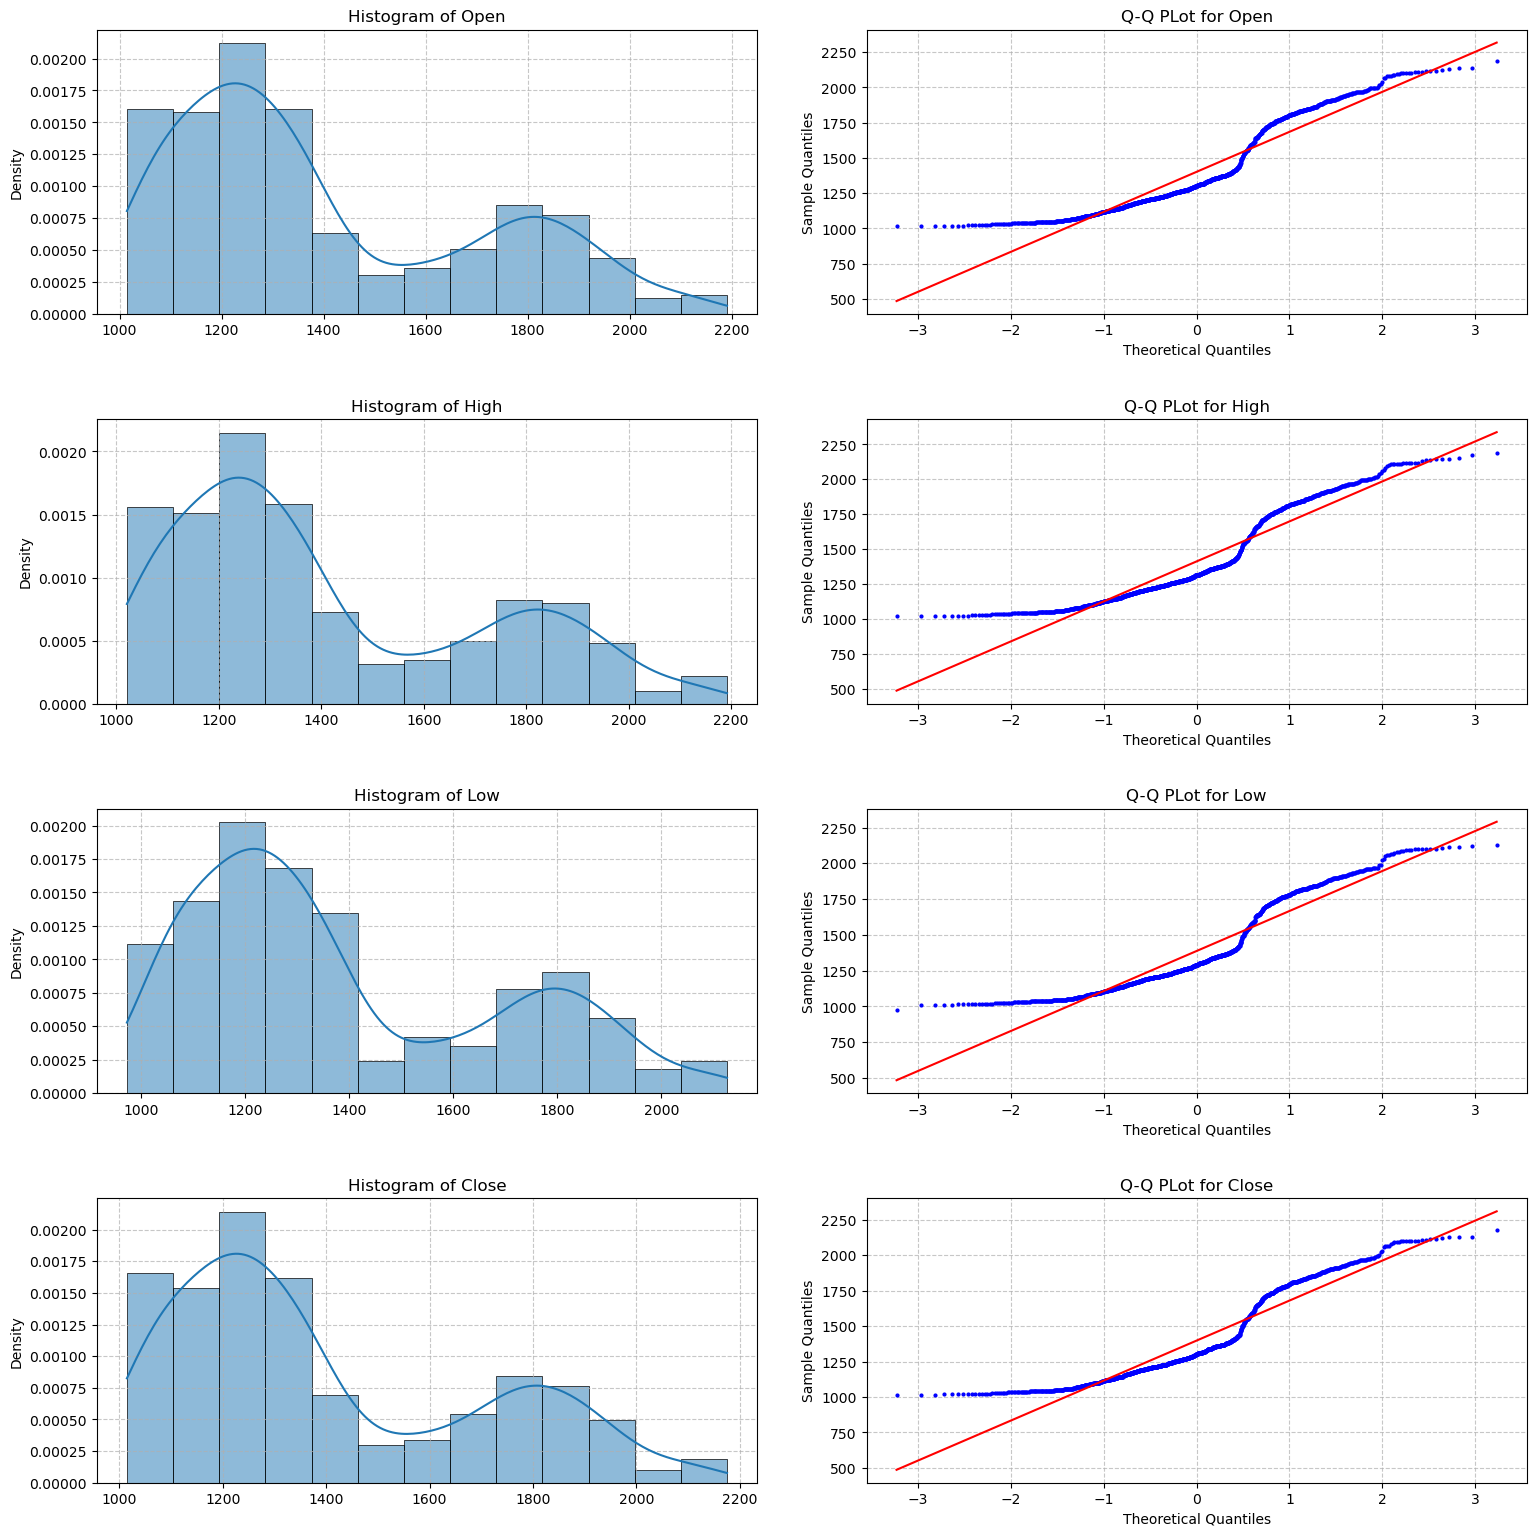

In [10]:
# Create a fig and axes for subplots
num_cols = len(numerical_columns)
fig, axes = plt.subplots(num_cols, 2, figsize=(16, num_cols*4))

# PLotting histograms and QQ plots for each numerical column
for i, col in enumerate(numerical_columns):
    # Histogram on the :eft subplot
    sns.histplot(df[col], kde=True, ax=axes[i, 0], stat='density', linewidth=0.5)
    axes[i, 0].set_title(f'Histogram of {col}') #f for describing col value
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('Density')
    axes[i, 0].grid(True, linestyle='--', alpha=0.7)

    # Q-Q plot on the right subplot
    stats.probplot(df[col], plot=axes[i, 1], dist='norm', fit=True)
    axes[i, 1].get_lines()[0].set_markersize(2.0) #Adjust marker size 
    axes[i, 1].grid(True, linestyle='--', alpha=0.7)
    axes[i, 1].set_title(f'Q-Q PLot for {col}')
    axes[i, 1].set_xlabel('Theoretical Quantiles')
    axes[i, 1].set_ylabel('Sample Quantiles')

#Adjust layout and display the plots
plt.tight_layout(pad=3.0)
plt.show()

### Normality Test

In [12]:
# Function to perform normality tests
def test_normality(df, col):
    print(f'column: {col}')

    #Shapiro-Wilk Test
    stat_shapiro, p_shapiro = shapiro(df[col])
    print(f'Shapiro-Wilk Test: Statistics={stat_shapiro:.3f},p-value={p_shapiro:.3f}')
    if p_shapiro > 0.05:
        print(f'Shapiro-Wilk Test : {col} looks normally distributed (fail to reject HO)')
    else:
        print(f'Shapiro-Wilk Test : {col} does not looks normally distributed (reject HO)')

    # Anderson-Darling Test
    result_anderson = anderson(df[col])
    print(f'Anderson-Darling Test: Statistics={result_anderson.statistic:.3f}')
    print(f'Anderson-Darling Test: Critical Values:{result_anderson.critical_values}')
    if result_anderson.statistic < result_anderson.critical_values[2]:
        print(f'Anderson-Darling Test: {col} looks normally distributed (fail to reject HO)')
    else:
        print(f'Anderson-Darling Test: {col} does not looks normally distributed (reject HO)')

    # Jarque-Bera Test
    jb_stat, p_val_jb = jarque_bera(df[col])
    print(f'Jarque-Bera Test: JB Statistics={jb_stat:.3f},p-value={p_val_jb:.3f}')
    if p_val_jb > 0.05:
        print(f'Jarque-Bera Test: {col} looks normally distributed (fail to reject HO)')
    else:
        print(f'Jarque-Bera Test: {col} does not looks normally distributed (reject HO)')

    # D'Agostino and Pearson's Test
    stat_agostino, p_agostino = normaltest(df[col])
    print(f"D'Agostino adn Pearson's Test: Statistics={stat_agostino:.3f},p-value={p_agostino:.3f}")
    if p_agostino > 0.05:
        print(f"D'Agostino and Pearson's Test: {col} looks normally distributed (fail to reject HO)")
    else:
        print(f"D'Agostino and Pearson's Test: {col} does not looks normally distributed (reject HO)")

    # Kolmogirov-Smirnov Test
    ks_stat, p_ks = kstest(df[col], 'norm')
    print(f'Kolmogirov-Smirnov Test: KS Statistics={ks_stat:.3f},p-value={p_ks:.3f}')
    if p_ks > 0.05:
        print(f'Kolmogirov-Smirnov Test: {col} looks normally distributed (fail to reject HO)')
    else:
        print(f'Kolmogirov-Smirnov Test: {col} does not looks normally distributed (reject HO)')

    # Lilliefors Test
    stat_lilliefors, p_lilliefors = lilliefors(df[col])
    print(f'Lilliefors Test: Statistics={stat_lilliefors:.3f},p-value={p_lilliefors:.3f}')
    if p_lilliefors > 0.05:
        print(f'Lilliefors Test: {col} looks normally distributed (fail to reject HO)')
    else:
        print(f'Lilliefors Test: {col} does not looks normally distributed (reject HO)')

    print('\n')

# Perform normality tests for each numerical column
for col in numerical_columns:
    test_normality(df, col)

column: Open
Shapiro-Wilk Test: Statistics=0.897,p-value=0.000
Shapiro-Wilk Test : Open does not looks normally distributed (reject HO)
Anderson-Darling Test: Statistics=44.305
Anderson-Darling Test: Critical Values:[0.574 0.654 0.784 0.915 1.088]
Anderson-Darling Test: Open does not looks normally distributed (reject HO)
Jarque-Bera Test: JB Statistics=124.836,p-value=0.000
Jarque-Bera Test: Open does not looks normally distributed (reject HO)
D'Agostino adn Pearson's Test: Statistics=142.029,p-value=0.000
D'Agostino and Pearson's Test: Open does not looks normally distributed (reject HO)
Kolmogirov-Smirnov Test: KS Statistics=1.000,p-value=0.000
Kolmogirov-Smirnov Test: Open does not looks normally distributed (reject HO)
Lilliefors Test: Statistics=0.159,p-value=0.001
Lilliefors Test: Open does not looks normally distributed (reject HO)


column: High
Shapiro-Wilk Test: Statistics=0.900,p-value=0.000
Shapiro-Wilk Test : High does not looks normally distributed (reject HO)
Anderson-D

In [13]:
def find_outliers_zscore(data, threshold=3):
    outliers_mask = pd.Series(index=data.columns, dtype=bool)

    for col in data.columns:
        if col in numerical_columns:  # Process only numerical columns
            mean = np.mean(data[col])
            std_dev = np.std(data[col])
            z_scores = np.abs((data[col] - mean) / std_dev)
            col_outliers_mask = z_scores > threshold
            outliers_mask[col] = col_outliers_mask.any()  # True if any outliers detected

    return outliers_mask

outliers_zscore_mask = find_outliers_zscore(df)
print("\nOutliers detected using Z-score method:")
for col, is_outlier in outliers_zscore_mask.items():
    print(f"{col}: {is_outlier}")


Outliers detected using Z-score method:
Symbol: True
Date: True
Open: False
High: False
Low: False
Close: False
Percent Change: True
Volume: True


In [14]:
def remove_outliers_iqr(data):
    cleaned_data = data.copy()

    for col in data.columns:
        if col in numerical_columns:  # Process only numerical columns
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)]

    return cleaned_data

cleaned_data_iqr = remove_outliers_iqr(df)
print("DataFrame after removing outliers using IQR method:")
print(cleaned_data_iqr)

DataFrame after removing outliers using IQR method:
       Symbol       Date     Open     High      Low    Close Percent Change  \
0     BANKING  7/29/2024  1604.17  1662.91  1569.17  1573.71         -0.04%   
1     BANKING  7/28/2024  1461.05  1574.81  1461.04  1574.34          9.90%   
2     BANKING  7/25/2024  1413.90  1434.64  1396.76  1432.58          1.35%   
3     BANKING  7/24/2024  1435.46  1452.12  1402.11  1413.44         -1.22%   
4     BANKING  7/23/2024  1399.35  1432.23  1374.74  1430.86          2.39%   
...       ...        ...      ...      ...      ...      ...            ...   
1126  BANKING   8/7/2019  1121.46  1126.77  1114.92  1123.57          0.00%   
1127  BANKING   8/6/2019  1131.07  1131.07  1118.32  1120.61          0.00%   
1128  BANKING   8/5/2019  1133.33  1134.83  1128.01  1129.97          0.00%   
1129  BANKING   8/4/2019  1136.52  1139.09  1131.52  1132.80          0.00%   
1130  BANKING   8/1/2019  1140.22  1143.82  1134.80  1136.29          0.00%   


# Exploratory Data Analysis

In [5]:
numeric_data = df[numerical_columns]

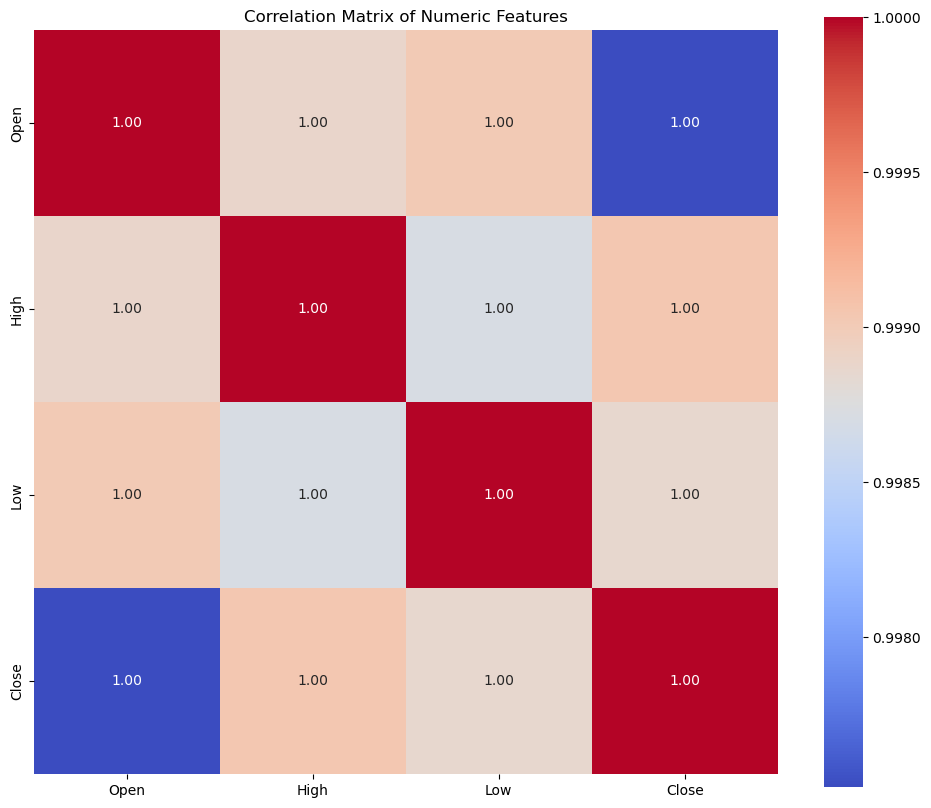

In [16]:
# Compute pairwise correlation of numeric columns
correlation_matrix = numeric_data.corr()

# Plotting correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

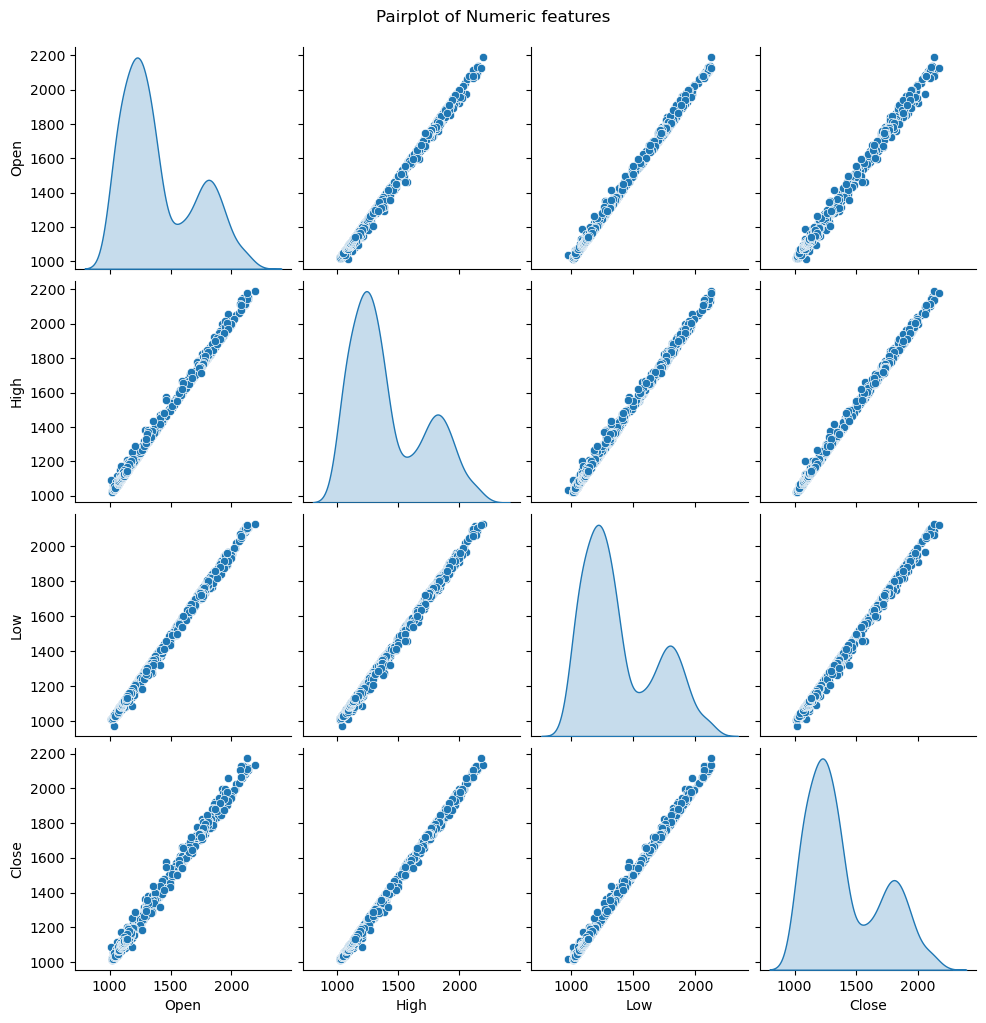

In [17]:
# Pairplot of numeric features
sns.pairplot(df[numerical_columns], diag_kind='kde')
plt.suptitle('Pairplot of Numeric features', y=1.02)
plt.show()

# Support & Resistance Functions

In [3]:
# Example support function
def support(df1, l, n1, n2):  # n1 and n2 are the number of candles before and after the current candle
    for i in range(l - n1 + 1, l + 1):
        if df1['Low'][i] > df1['Low'][i - 1]:
            return False
    for i in range(l + 1, l + n2 + 1):
        if df1['Low'][i] < df1['Low'][i - 1]:
            return False
    return True

# Example resistance function
def resistance(df1, l, n1, n2):  # n1 and n2 are the number of candles before and after the current candle
    for i in range(l - n1 + 1, l + 1):
        if df1['High'][i] < df1['High'][i - 1]:
            return False
    for i in range(l + 1, l + n2 + 1):
        if df1['High'][i] > df1['High'][i - 1]:
            return False
    return True


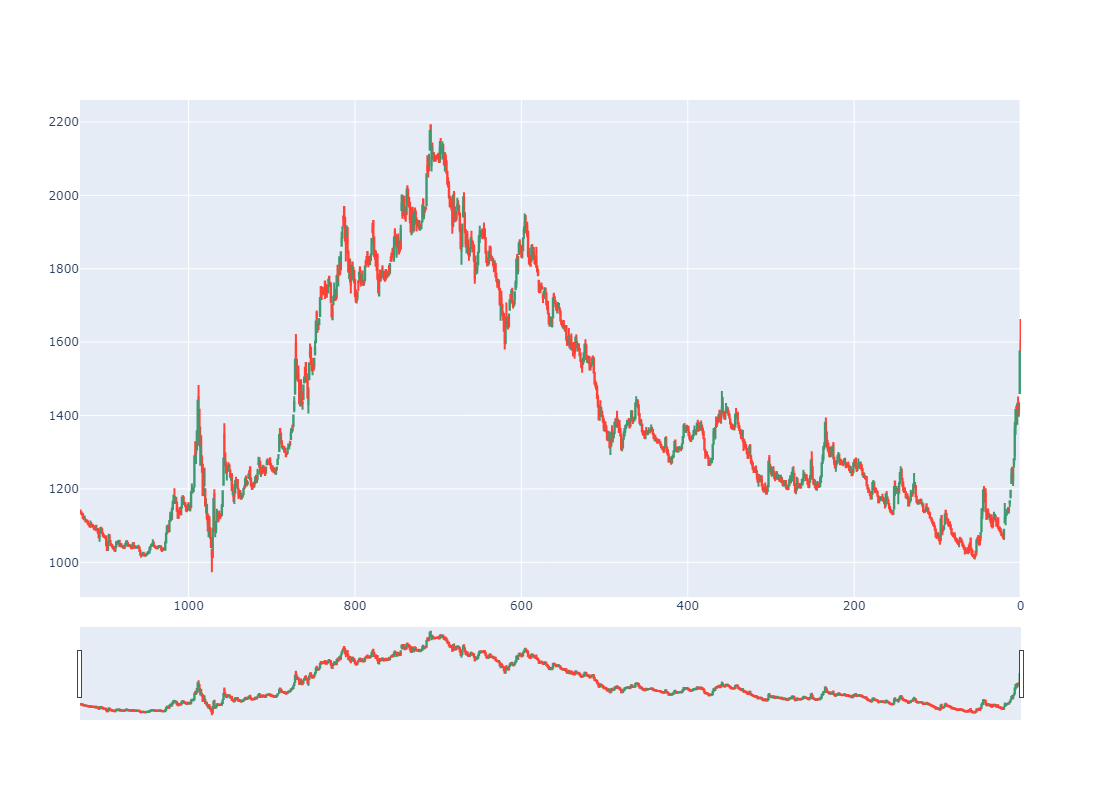

In [11]:
dfpl = df[0:1500]

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])
fig.update_layout(
    xaxis=dict(
        autorange='reversed'
    ),
    height = 800,
    width = 1100
)
fig.show()

### Finding Support & Resistance level

In [4]:
sr = []
n1=3
n2=2
for row in range(n1, len(df) - n2): #len(df)-n2
    if support(df, row, n1, n2):
        sr.append((row, df['Low'][row],1))
    if resistance(df, row, n1, n2):
        sr.append((row, df['High'][row],2))
print(sr)

[(32, 1137.55, 2), (41, 1115.47, 1), (49, 1046.06, 1), (55, 1007.78, 1), (60, 1064.69, 2), (73, 1069.81, 2), (90, 1141.86, 2), (116, 1134.04, 1), (120, 1174.16, 2), (123, 1157.9, 1), (128, 1243.72, 2), (144, 1261.82, 2), (147, 1158.36, 1), (154, 1128.54, 1), (161, 1194.68, 2), (180, 1172.29, 1), (222, 1247.02, 1), (225, 1327.8, 2), (229, 1286.13, 1), (234, 1394.8, 2), (251, 1302.51, 2), (254, 1201.51, 1), (273, 1261.5, 2), (280, 1196.66, 1), (293, 1248.77, 2), (302, 1292.37, 2), (305, 1184.5, 1), (311, 1237.39, 2), (325, 1322.09, 2), (359, 1466.84, 2), (374, 1262.23, 1), (384, 1386.46, 2), (408, 1302.88, 1), (426, 1343.26, 2), (444, 1375.85, 2), (466, 1376.9, 1), (479, 1302.72, 1), (505, 1441.52, 2), (514, 1563.89, 2), (517, 1521.77, 1), (527, 1516.48, 1), (561, 1734.21, 2), (572, 1749.57, 2), (599, 1827.79, 1), (610, 1691.6, 1), (620, 1580.04, 1), (638, 1863.5, 2), (641, 1806.38, 1), (660, 1903.79, 2), (663, 1821.92, 1), (669, 2008.51, 2), (672, 1811.16, 1), (677, 1993.64, 2), (722, 1

### Lining the support and resistance level

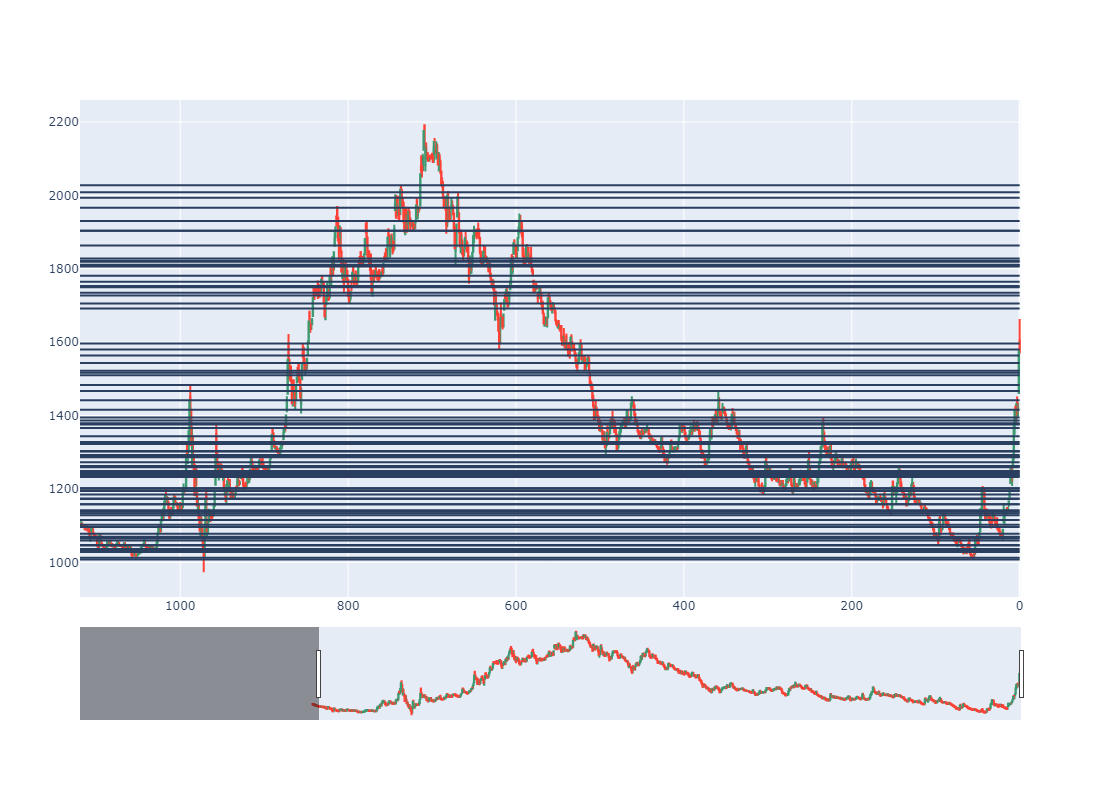

In [13]:
s = 0
e = 1500

dfpl = df[s:e]

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.update_layout(
    xaxis=dict(
        autorange='reversed'
    ),
    height = 800,
    width = 1100
)
    
c=0
while (1):
    if(c>len(sr)-1 ):#or sr[c][0]>e
        break
    fig.add_shape(type='line', x0=s, y0=sr[c][1],
                  x1=e,
                  y1=sr[c][1]
                  )#x0=sr[c][0]-5 x1=sr[c][0]+5
    c+=1
fig.show()

In [5]:
plotlist1 = [x[1] for x in sr if x[2]==1]
plotlist2 = [x[1] for x in sr if x[2]==2]
plotlist1.sort()
plotlist2.sort()

for i in range(1,len(plotlist1)):
    if(i>=len(plotlist1)):
        break
    if abs(plotlist1[i]-plotlist1[i-1])<=0.005:
        plotlist1.pop(i)

for i in range(1,len(plotlist2)):
    if(i>=len(plotlist2)):
        break
    if abs(plotlist2[i]-plotlist2[i-1])<=0.005:
        plotlist2.pop(i)
plotlist2
#plt.hist(plotlist, bins=10, alpha=0.5)

[1047.32,
 1059.37,
 1064.69,
 1069.81,
 1077.54,
 1096.5,
 1102.19,
 1137.55,
 1141.86,
 1174.16,
 1194.68,
 1201.76,
 1237.39,
 1243.72,
 1248.77,
 1258.77,
 1261.5,
 1261.82,
 1272.98,
 1287.72,
 1292.37,
 1302.51,
 1322.09,
 1327.8,
 1343.26,
 1366.29,
 1375.85,
 1378.83,
 1386.46,
 1394.8,
 1441.52,
 1466.84,
 1483.16,
 1542.99,
 1563.89,
 1596.12,
 1734.21,
 1749.57,
 1780.8,
 1809.38,
 1818.83,
 1863.5,
 1903.79,
 1930.18,
 1966.05,
 1993.64,
 2008.51,
 2027.15]

In [6]:
plotlist1

[1007.78,
 1012.65,
 1028.17,
 1031.78,
 1036.51,
 1046.06,
 1068.44,
 1115.47,
 1128.54,
 1134.04,
 1157.9,
 1158.36,
 1172.29,
 1184.5,
 1196.66,
 1201.51,
 1232.62,
 1235.22,
 1240.1,
 1247.02,
 1262.23,
 1286.13,
 1288.05,
 1302.72,
 1302.88,
 1376.9,
 1415.46,
 1510.0,
 1516.48,
 1521.77,
 1580.04,
 1691.6,
 1705.25,
 1727.24,
 1753.16,
 1764.56,
 1806.38,
 1811.16,
 1821.92,
 1827.79,
 1903.15]

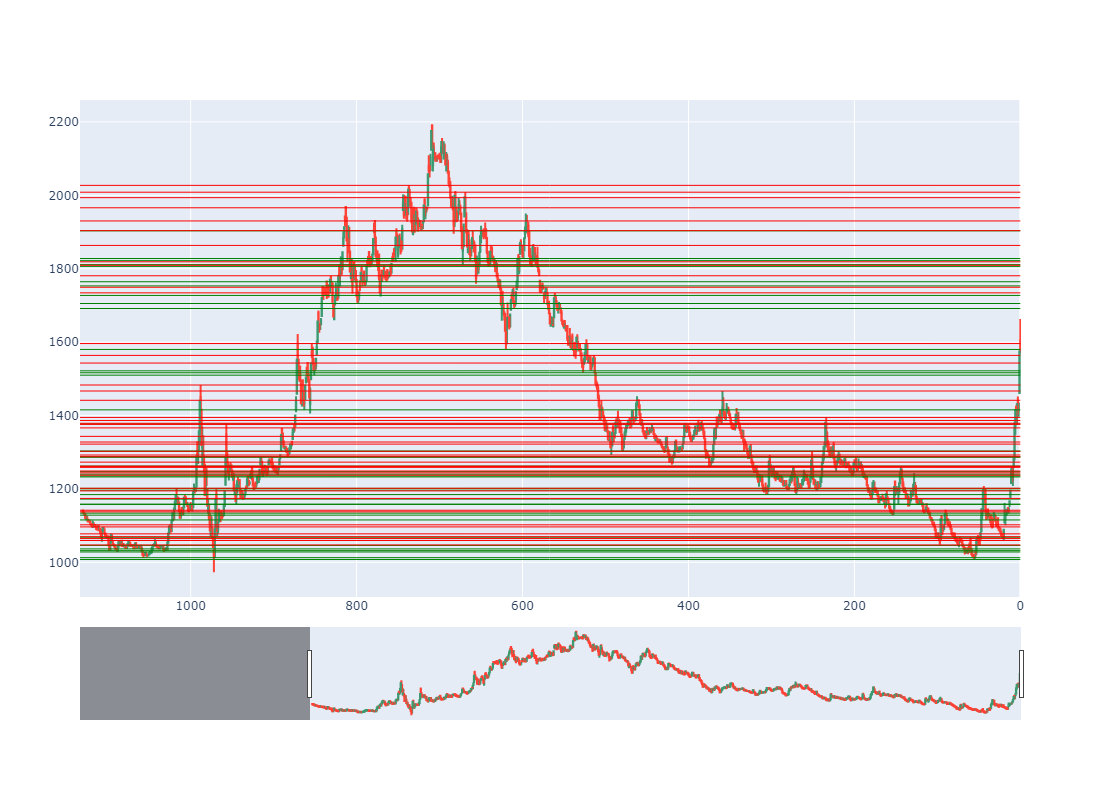

In [10]:
s = 0
e = 1500
dfpl = df[s:e]

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.update_layout(
    xaxis=dict(
        autorange='reversed'
    ),
    height = 800,
    width = 1100
)

c=0
while (1):
    if(c>len(plotlist1)-1 ):#or sr[c][0]>e
        break
    fig.add_shape(type='line', x0=s, y0=plotlist1[c],
                  x1=e,
                  y1=plotlist1[c],
                  line=dict(color="Green",width=1)
                  )
    c+=1

c=0
while (1):
    if(c>len(plotlist2)-1 ):#or sr[c][0]>e
        break
    fig.add_shape(type='line', x0=s, y0=plotlist2[c],
                  x1=e,
                  y1=plotlist2[c],
                  line=dict(color="Red",width=1)
                  )
    c+=1    

fig.show()

In [7]:
ss = []
rr = []
n1=2
n2=2
for row in range(3, len(df)-n2): #len(df)-n2
    if support(df, row, n1, n2):
        ss.append((row,df['Low'][row]))
    if resistance(df, row, n1, n2):
        rr.append((row,df['High'][row]))

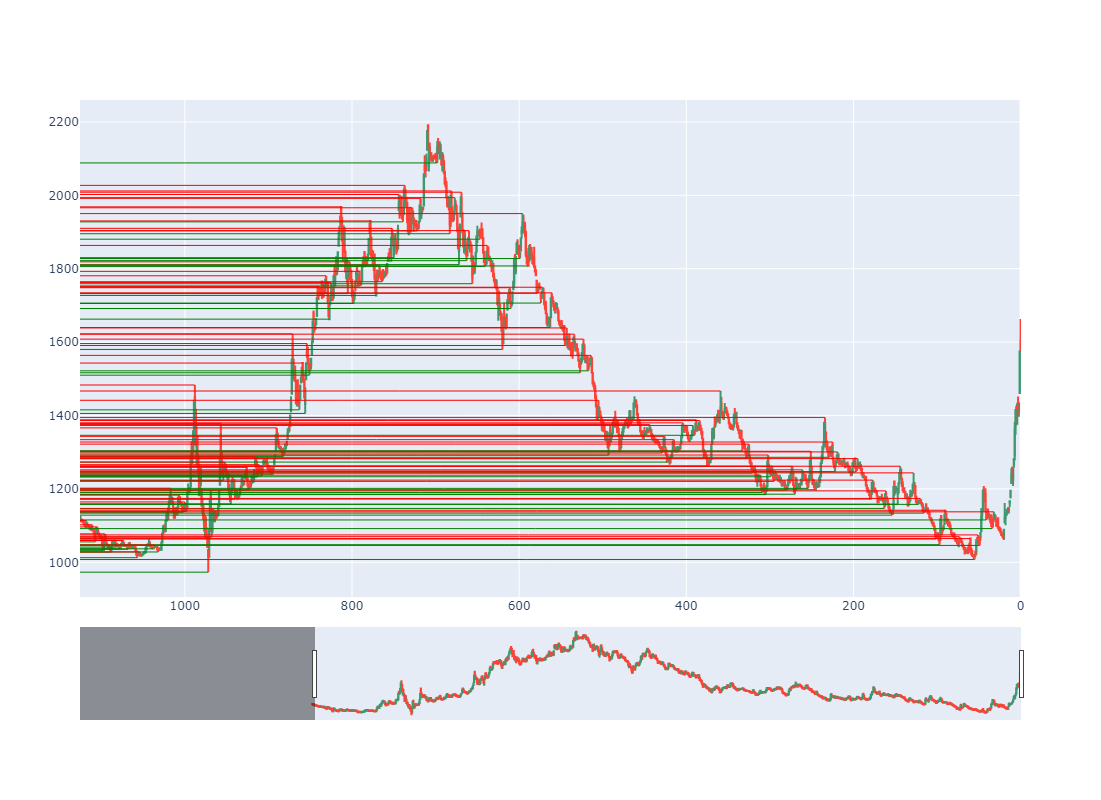

In [58]:
s = 0
e = 1500
dfpl = df[s:e]

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.update_layout(
    xaxis=dict(
        autorange='reversed'
    ),
    height = 800,
    width = 1100
)

c=0
while (1):
    if(c>len(ss)-1 ):
        break
    fig.add_shape(type='line', x0=ss[c][0], y0=ss[c][1],
                  x1=e,
                  y1=ss[c][1],
                  line=dict(color="Green",width=1)
                  )
    c+=1

c=0
while (1):
    if(c>len(rr)-1 ):
        break
    fig.add_shape(type='line', x0=rr[c][0], y0=rr[c][1],
                  x1=e,
                  y1=rr[c][1],
                  line=dict(color="Red",width=1)
                  )
    c+=1    

fig.show()

In [8]:
length = len(df)
high = list(df['High'])
low = list(df['Low'])
close = list(df['Close'])
open = list(df['Open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

In [9]:
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df['High'][l]-min(levels, key=lambda x:abs(x-df['High'][l])))<=lim
    c2 = abs(max(df['Open'][l],df['Close'][l])-min(levels, key=lambda x:abs(x-df['High'][l])))<=lim
    c3 = min(df['Open'][l],df['Close'][l])<min(levels, key=lambda x:abs(x-df['High'][l]))
    c4 = df['Low'][l]<min(levels, key=lambda x:abs(x-df['High'][l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df['Low'][l]-min(levels, key=lambda x:abs(x-df['Low'][l])))<=lim
    c2 = abs(min(df['Open'][l],df['Close'][l])-min(levels, key=lambda x:abs(x-df['Low'][l])))<=lim
    c3 = max(df['Open'][l],df['Close'][l])>min(levels, key=lambda x:abs(x-df['Low'][l]))
    c4 = df['High'][l]>min(levels, key=lambda x:abs(x-df['Low'][l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

### Generating Buy and Sell Signal 

In [10]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df['Low'][subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df['High'][subrow])
    #!!!! parameters
    if (closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif(closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0

In [11]:
df['signal']=signal

In [20]:
df[df['signal']==2].count()

Symbol            86
Date              86
Open              86
High              86
Low               86
Close             86
Percent Change    86
Volume            86
signal            86
dtype: int64

In [16]:
df

Symbol       Date     Open     High      Low    Close Percent Change  \
0     BANKING  7/29/2024  1604.17  1662.91  1569.17  1573.71         -0.04%   
1     BANKING  7/28/2024  1461.05  1574.81  1461.04  1574.34          9.90%   
2     BANKING  7/25/2024  1413.90  1434.64  1396.76  1432.58          1.35%   
3     BANKING  7/24/2024  1435.46  1452.12  1402.11  1413.44         -1.22%   
4     BANKING  7/23/2024  1399.35  1432.23  1374.74  1430.86          2.39%   
...       ...        ...      ...      ...      ...      ...            ...   
1126  BANKING   8/7/2019  1121.46  1126.77  1114.92  1123.57          0.00%   
1127  BANKING   8/6/2019  1131.07  1131.07  1118.32  1120.61          0.00%   
1128  BANKING   8/5/2019  1133.33  1134.83  1128.01  1129.97          0.00%   
1129  BANKING   8/4/2019  1136.52  1139.09  1131.52  1132.80          0.00%   
1130  BANKING   8/1/2019  1140.22  1143.82  1134.80  1136.29          0.00%   

                Volume  signal  
0     4,334,529,130.90       0  
1     3,962,874,692.70       0  
2     1,742,766,269.40       0  
3     1,958,365,254.40       0  
4     1,843,392,041.30       0  
...                ...     ...  
1126    176,374,000.00       0  
1127    278,084,992.00       0  
1128    183,203,008.00       0  
1129    203,803,008.00       0  
1130    161,744,000.00       0  

[1131 rows x 9 columns]

In [12]:
def SIGNAL():
    return df.signal

# Backtesting

In [13]:
from backtesting import Strategy
from backtesting import Backtest

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 95
            tp1 = self.data.Close[-1] + 50
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 95
            tp1 = self.data.Close[-1] - 50
            self.sell(sl=sl1, tp=tp1)

C:\Users\User\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [28]:
!pip install backtesting

     ---------------------------------------- 0.0/175.5 kB ? eta -:--:--
     ---- -------------------------------- 20.5/175.5 kB 330.3 kB/s eta 0:00:01
     -------- ---------------------------- 41.0/175.5 kB 393.8 kB/s eta 0:00:01
     ----------------------- ------------ 112.6/175.5 kB 819.2 kB/s eta 0:00:01
     -------------------------------------- 175.5/175.5 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173963 sha256=57245c1d45d9da074a83e1be76cc067d93891b3c12f329115a4586e92a758a7f
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\b6\46\69\c2cb2ec77dea61c5ff9e68534250c3bc8e85f6fdb9ca69f31d
Successfully built backtesting


In [18]:
bt = Backtest(df, MyCandlesStrat, cash=1000000, commission=.002)
stat = bt.run()
print(stat)

Start                                     0.0
End                                    1130.0
Duration                               1130.0
Exposure Time [%]                   66.136163
Equity Final [$]                2211605.71432
Equity Peak [$]                 2362072.24492
Return [%]                         121.160571
Buy & Hold Return [%]              -27.795464
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -29.280282
Avg. Drawdown [%]                   -3.335728
Max. Drawdown Duration                  322.0
Avg. Drawdown Duration              18.519231
# Trades                                 89.0
Win Rate [%]                         67.41573
Best Trade [%]                       7.327852
Worst Trade [%]                    -10.106232
Avg. Trade [%]                    

C:\Users\User\AppData\Local\Temp\ipykernel_6460\758021114.py:1: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=1000000, commission=.002)


In [15]:
from bokeh.io import show
# Plot the results
plot = bt.plot()

# Function to invert x-axis for all children
def invert_x_axis(plot):
    if isinstance(plot, tuple):
        for p in plot:
            invert_x_axis(p)
    elif hasattr(plot, 'x_range'):
        plot.x_range.start, plot.x_range.end = plot.x_range.end, plot.x_range.start
    if hasattr(plot, 'children'):
        for child in plot.children:
            invert_x_axis(child)

# Apply the function to the plot
invert_x_axis(plot)

# Display the plot
show(plot)

C:\Users\User\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\User\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


# Integration of Machine Learning For predicting Future Movements and Generating Buy/Sell Signal

In [3]:
df.head()

Symbol       Date     Open     High      Low    Close Percent Change  \
0  BANKING  7/29/2024  1604.17  1662.91  1569.17  1573.71         -0.04%   
1  BANKING  7/28/2024  1461.05  1574.81  1461.04  1574.34          9.90%   
2  BANKING  7/25/2024  1413.90  1434.64  1396.76  1432.58          1.35%   
3  BANKING  7/24/2024  1435.46  1452.12  1402.11  1413.44         -1.22%   
4  BANKING  7/23/2024  1399.35  1432.23  1374.74  1430.86          2.39%   

             Volume  
0  4,334,529,130.90  
1  3,962,874,692.70  
2  1,742,766,269.40  
3  1,958,365,254.40  
4  1,843,392,041.30

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.set_index('Date', inplace=True)

# Select the columns you need
data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [10]:
# Example function to clean data
def clean_data(df):
    # Remove commas and other non-numeric characters, then convert to float
    for col in df.columns:
        df[col] = df[col].replace({',': ''}, regex=True).astype(float)
    return df

# Clean the data
data = clean_data(data)

C:\Users\User\AppData\Local\Temp\ipykernel_13380\600392520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace({',': ''}, regex=True).astype(float)
C:\Users\User\AppData\Local\Temp\ipykernel_13380\600392520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace({',': ''}, regex=True).astype(float)
C:\Users\User\AppData\Local\Temp\ipykernel_13380\600392520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

### Fetaure Engineering

##### Additional features can be integrated like moving averages and RSI 

In [11]:
# Example: Adding Moving Averages
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df.dropna(inplace=True)

In [12]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

### LSTM Model

In [14]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_train.reshape(-1, 1))
#scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Index for 'Close' price
    return np.array(X), np.array(y)

seq_length = 100  # or the length you decide to use
train_size = int(len(scaled_data) * 0.8)
X_train, y_train = create_sequences(scaled_data[:train_size], seq_length)
X_test, y_test = create_sequences(scaled_data[train_size:], seq_length)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=50)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.0815
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0034
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0017
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0012
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0012
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0013
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0011
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0012
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 9.6040e-04
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0010
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 9.9283e-04
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 8.9055e-04
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 8.4420e-04
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 8.7956e-04
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━

In [15]:
!pip install tensorflow

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ------------------------- -------------- 30.7/48.7 kB ? eta -:--:--
     -------------------------------------- 48.7/48.7 kB 818.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.2/385.2 MB 5.8 MB/s eta 0:01:07
   ---------------------------------------- 0.5/385.2 MB 4.8 MB/s eta 0:01:21
   ---------------------------------------- 0.6/385.2 MB 4.3 MB/s eta 0:01:29
   ---------------------------------------- 1.1/385.2 MB 6.2 MB/s eta 0:01:03
   ---------------------------------------- 1.6/385.2 MB 6.6 MB/s eta 0:00:58
   ---------------------------------------- 2.2/385.2 MB 7.6 MB/s eta 0:00:51
   ---------------------------------------- 2.8/385.2 MB 8.4 MB/s eta 0:00:46
   ---------------------------------------- 3.3/385.2 MB 8.7 MB/s eta 0:00:44
   ---------------------------------------- 3.7/385.2 MB 8.5 MB/s eta 0:00:45
  

In [16]:
# Predict on the test set
predictions = model.predict(X_test)

# Reshape predictions for inverse transformation
predictions_reshaped = predictions.reshape(-1, 1)

# Inverse transform predictions
predictions_original = scaler.inverse_transform(
    np.concatenate([np.zeros((len(predictions_reshaped), data.shape[1] - 1)), predictions_reshaped], axis=1)
)[:, -1]

# Inverse transform actual values
y_test_reshaped = y_test.reshape(-1, 1)
y_test_original = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test_reshaped), data.shape[1] - 1)), y_test_reshaped], axis=1)
)[:, -1]

# Now you can compare predictions_original and y_test_original


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


In [48]:
# Define thresholds for generating buy and sell signals
buy_threshold = 0.02  # 2% above previous close
sell_threshold = -0.02  # 2% below previous close

buy_signals = []
sell_signals = []

for i in range(1, len(predictions_original)):
    if predictions_original[i] > y_test_original[i - 1] * (1 + buy_threshold):
        buy_signals.append((i, y_test_original[i]))
    elif predictions_original[i] < y_test_original[i - 1] * (1 + sell_threshold):
        sell_signals.append((i, y_test_original[i]))

print("Buy Signals:", buy_signals)
print("Sell Signals:", sell_signals)

Buy Signals: [(3, 0.1086506389884932), (4, 0.10590277592115126), (5, 0.1773718234010047), (7, 0.04939522764975072), (8, 0.07008212512985983), (9, 0.09112173339174728), (10, 0.1125386601643741), (19, 0.25499280312117645), (27, 0.2767870484045428), (28, 0.27288262207602093), (30, 0.19584402527459938), (31, 0.1989199913947585), (34, 0.1547901307908778), (35, 0.16212323402133674), (45, 0.14322449817908003), (46, 0.14974554635381693), (47, 0.15066423490170452), (48, 0.1358913949486211), (49, 0.15103335083612365), (50, 0.16843921778806326), (55, 0.1540929118036418), (56, 0.13181471451737028), (57, 0.14031258358532947), (58, 0.12816456805478166), (59, 0.1057715347000244), (60, 0.10693630053752462), (61, 0.1161313885927199), (62, 0.1005300884312734), (63, 0.0793100234903368), (64, 0.06557891072994718), (65, 0.06739168009676083), (66, 0.06461920930045745), (67, 0.062945883731091), (68, 0.06475865309790475), (69, 0.07185388161507154), (70, 0.07128790384896218), (71, 0.0709433956435044), (72, 0.0

In [49]:
def SIGNAL():
    signals = [0] * len(df)
    for idx, _ in buy_signals:
        signals[idx] = 2  # 2 indicates a buy signal
    for idx, _ in sell_signals:
        signals[idx] = 1  # 1 indicates a sell signal
    return signals

df['signal'] = SIGNAL()

# Update your strategy to use the new signals
class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1[-1] == 2:
            sl1 = self.data.Close[-1] - 95
            tp1 = self.data.Close[-1] + 50
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1[-1] == 1:
            sl1 = self.data.Close[-1] + 95
            tp1 = self.data.Close[-1] - 50
            self.sell(sl=sl1, tp=tp1)

bt = Backtest(df, MyCandlesStrat, cash=1000000, commission=.002)
stat = bt.run()
print(stat)

C:\Users\User\AppData\Local\Temp\ipykernel_4260\789091895.py:28: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(df, MyCandlesStrat, cash=1000000, commission=.002)


Start                     2019-08-01 00:00:00
End                       2024-05-16 00:00:00
Duration                   1750 days 00:00:00
Exposure Time [%]                   15.341959
Equity Final [$]                1164902.45062
Equity Peak [$]                 1689041.13132
Return [%]                          16.490245
Buy & Hold Return [%]               -7.469924
Return (Ann.) [%]                    5.288925
Volatility (Ann.) [%]               17.292375
Sharpe Ratio                         0.305853
Sortino Ratio                        0.436312
Calmar Ratio                         0.146355
Max. Drawdown [%]                  -36.137567
Avg. Drawdown [%]                   -5.210992
Max. Drawdown Duration     1535 days 00:00:00
Avg. Drawdown Duration      180 days 00:00:00
# Trades                                   55
Win Rate [%]                        89.090909
Best Trade [%]                       4.703469
Worst Trade [%]                     -9.332043
Avg. Trade [%]                    

In [34]:
print("Predictions shape:", predictions.shape)
print("y_test shape:", y_test.shape)

Predictions shape: (166, 1)
y_test shape: (166,)


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make predictions
predictions = model.predict(X_test)
train_predictions = model.predict(X_train)

# Rescale predictions and actual values
# Assuming scaler was fitted on 'Close' prices
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
train_predictions_rescaled = scaler.inverse_transform(train_predictions)
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
train_mse = mean_squared_error(y_train_rescaled, train_predictions_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, train_predictions_rescaled)

print(f'Mean Squared Error (MSE) on Test Data: {mse}')
print(f'Mean Absolute Error (MAE) on Test Data: {mae}')

print(f'Mean Squared Error (MSE) on Training Data: {train_mse}')
print(f'Mean Absolute Error (MAE) on Training Data: {train_mae}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Squared Error (MSE) on Test Data: 0.0006520466349794735
Mean Absolute Error (MAE) on Test Data: 0.017864292950994815
Mean Squared Error (MSE) on Training Data: 0.00040294520209978616
Mean Absolute Error (MAE) on Training Data: 0.015567616442502416


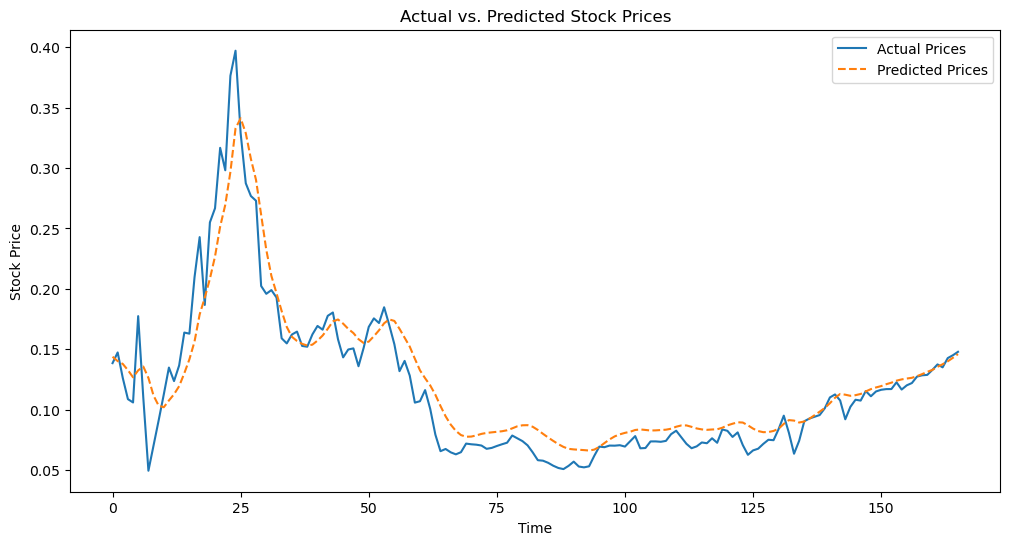

In [55]:
# Plotting for test data
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(predictions_rescaled, label='Predicted Prices', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [47]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 4.5656e-04 - val_loss: 6.2383e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 3.8604e-04 - val_loss: 5.9127e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 4.1782e-04 - val_loss: 5.8913e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 3.4414e-04 - val_loss: 8.9327e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.1991e-04 - val_loss: 0.0013
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 4.5570e-04 - val_loss: 0.0014
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.9246e-04 - val_loss: 0.0011
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.1124e-04 - val_loss: 8.3682e-04
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.9830e-04 - val_loss: 6.0022e-04
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 4.0127e-04 - val_loss: 6.0720e-04
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 4.0056e-04 - val_loss

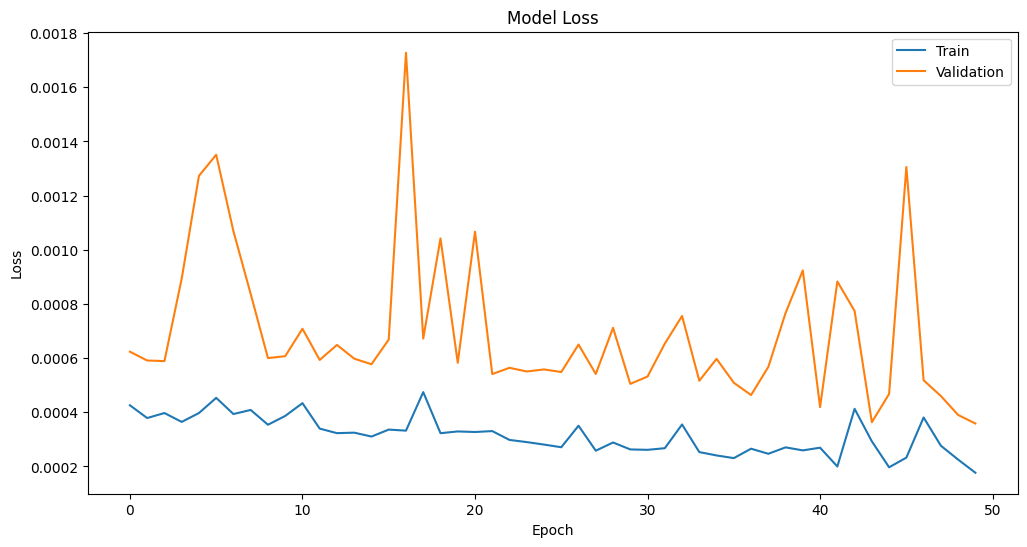

In [48]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

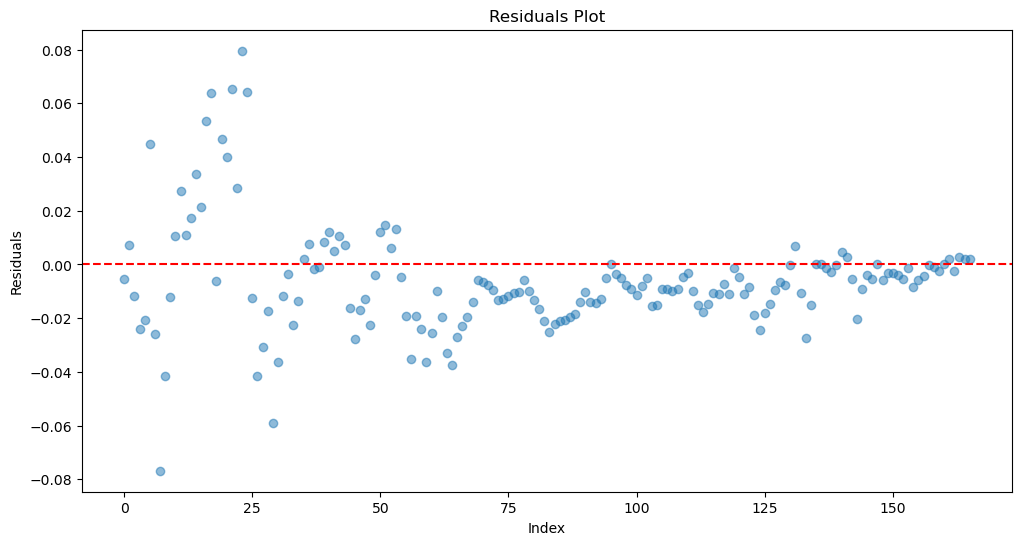

In [58]:
residuals = y_test_rescaled - predictions_rescaled

plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

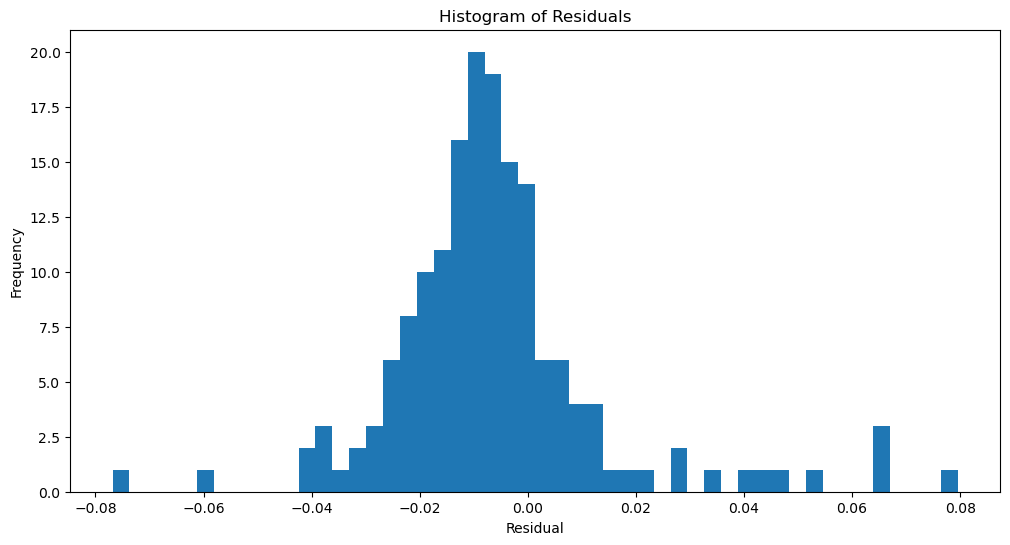

In [59]:
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [19]:
# Save the model to a folder named 'ML_MODEL'
if not os.path.exists('ML_Model'):
    os.makedirs('ML_Model')

model_path = 'ML_Model/LSTM_model.pkl'
joblib.dump(model, model_path)
print(f'Model saved at {model_path}')

Model saved at ML_Model/LSTM_model.pkl


In [18]:
model.save('LSTM_model.h5')

### Arima Model

In [66]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [67]:
train_size = int(len(df) * 0.8)

In [68]:
train_data = data['Close'][:train_size]
test_data = data['Close'][train_size:]

In [69]:
model = ARIMA(train_data, order=(5, 1, 0))  # Adjust order as needed
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_data))

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequ

In [72]:
# Ensure predictions are rescaled to match the original scale (if scaled initially)
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(test['Close'].values.reshape(-1, 1))

# Verify lengths
print(f'Length of y_test_rescaled: {len(y_test_rescaled)}')
print(f'Length of predictions_rescaled: {len(predictions_rescaled)}')

Length of y_test_rescaled: 217
Length of predictions_rescaled: 166


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7607.136, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7627.728, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7616.224, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7613.118, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7625.836, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7608.859, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7608.750, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7606.709, Time=1.85 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7610.322, Time=0.71 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=7606.003, Time=1.77 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=7610.178, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=7609.271, Time=1.37 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7607.763, Time=2.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7606.367, Time=1.58 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



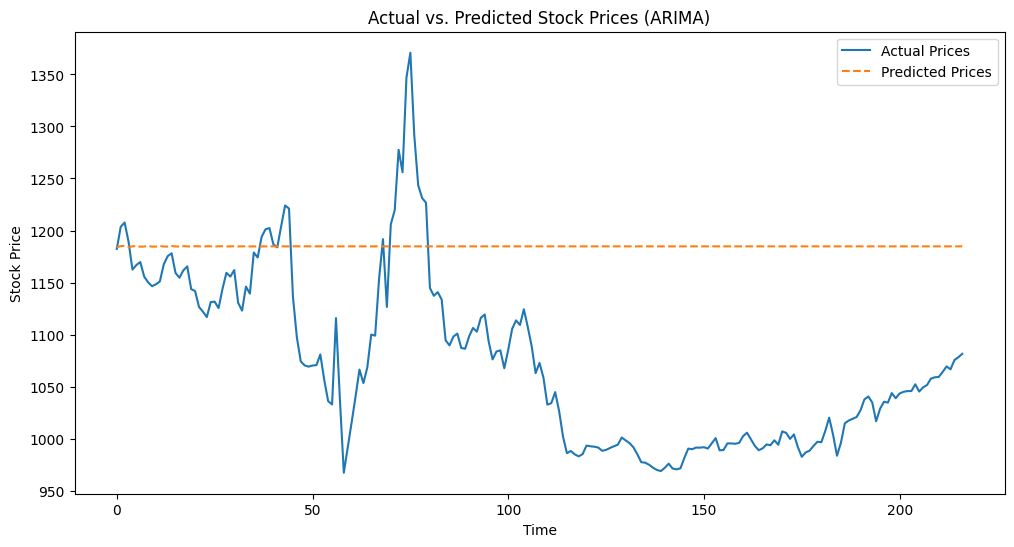

In [80]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Use auto_arima to find the best model
model = pm.auto_arima(train['Close'], seasonal=False, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Summary of the model
print(model.summary())

# Make predictions on the test set
predictions1 = model.predict(n_periods=len(test))
# Make predictions on the training set
train_predictions1 = model.predict_in_sample()

# Convert predictions to numpy array and reshape for inverse transformation
predictions1_rescaled = scaler.inverse_transform(predictions1.to_numpy().reshape(-1, 1))
y_test_rescaled1 = scaler.inverse_transform(test['Close'].values.reshape(-1, 1))
# Convert predictions to numpy array and reshape for inverse transformation
train_predictions_rescaled1 = scaler.inverse_transform(np.array(train_predictions1).reshape(-1, 1))
y_train_rescaled1 = scaler.inverse_transform(train['Close'].values.reshape(-1, 1))

# Calculate Mean Squared Error and Mean Absolute Error for test data
mse1 = mean_squared_error(y_test_rescaled1, predictions1_rescaled)
mae1 = mean_absolute_error(y_test_rescaled1, predictions1_rescaled)
# Calculate Mean Squared Error and Mean Absolute Error for training data
train_mse1 = mean_squared_error(y_train_rescaled1, train_predictions_rescaled1)
train_mae1 = mean_absolute_error(y_train_rescaled1, train_predictions_rescaled1)

print(f'Mean Squared Error (MSE) on Test Data: {mse1}')
print(f'Mean Absolute Error (MAE) on Test Data: {mae1}')
print(f'Mean Squared Error (MSE) on Training Data: {train_mse1}')
print(f'Mean Absolute Error (MAE) on Training Data: {train_mae1}')

# Plotting for test data
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(predictions1_rescaled, label='Predicted Prices', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices (ARIMA)')
plt.legend()
plt.show()

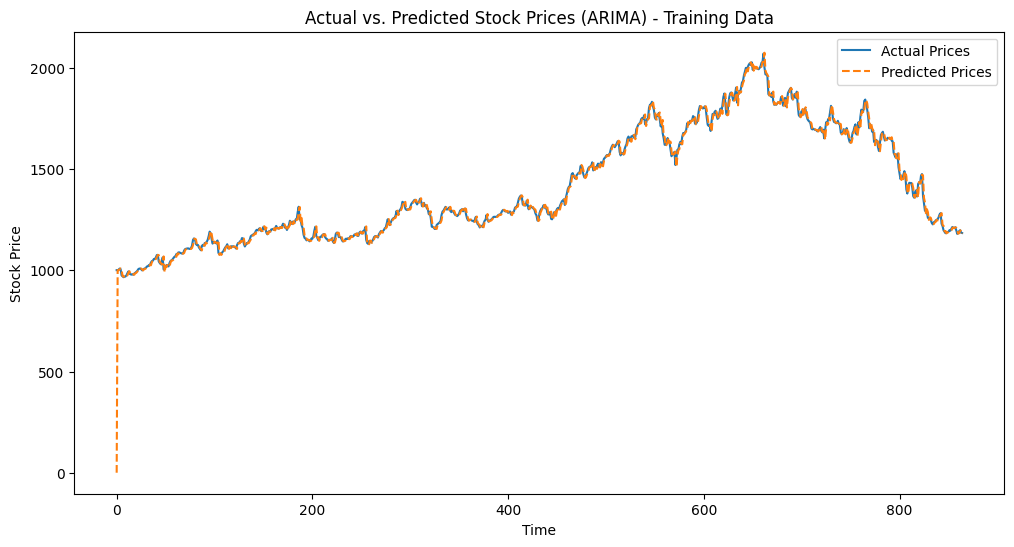

In [81]:
# Plotting for training data
plt.figure(figsize=(12, 6))
plt.plot(y_train_rescaled1, label='Actual Prices')
plt.plot(train_predictions_rescaled1, label='Predicted Prices', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices (ARIMA) - Training Data')
plt.legend()
plt.show()

In [83]:
# Save the model to a folder named 'ML_MODEL'
if not os.path.exists('ML_Model'):
    os.makedirs('ML_Model')

model_path = 'ML_Model/ARIMA_model.pkl'
joblib.dump(model, model_path)
print(f'Model saved at {model_path}')

Model saved at ML_Model/ARIMA_model.pkl


In [20]:
import tensorflow as tf
print(tf.__version__)

2.17.0
